In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [74]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time

# Reading and Running Simulations

In [5]:
file_name = "basic_chemotax.par"
output_file = "data_cellcount_testing.txt"

mcs = 1000
season_experiment = 1
season_duration = 1000

create_config(file_name, {'mcs': mcs,
                          'season_experiment': season_experiment,
                          'season_duration': season_duration, 
                         'keylock_list_filename': '../data/keylock/KL_l24_14_16_g6.dat',
                         'evolsim': 1,
                        'mut_rate': 0.0})

In [6]:
execute_experiment(file_name,0)

Opening ../data/parameters/basic_chemotax.par for reading
[T  = 1.600000e+01]
[target_area  = 50]
[half_div_area  = 500]
[half_div_area_2  = -1]
[target_length  = 0]
[lambda  = 5.000000e+00]
[lambda2  = 0.000000e+00]
[keylock_list_filename  = ../data/keylock/KL_l24_14_16_g6.dat]
[conn_diss  = 0]
[vecadherinknockout  = false]
[extensiononly  = false]
[chemotaxis  = 0]
[border_energy  = 100]
[neighbours  = 2]
[min_area_for_life  = 4]
[key_lock_length  = 24]
[periodic_boundaries  = false]
[n_chem  = 0]
[n_init_cells  = 100]
[size_init_cells  = 25]
[sizex  = 500]
[sizey  = 500]
[divisions  = 0]
[mcs  = 1000]
[rseed  = -1]
[subfield  = 1.000000e+00]
[relaxation  = 0]
[storage_stride  = 1000]
[graphics  = false]
[store  = true]
[datadir  = data_film2]
[datafile  = data_cellcount.txt]
[save_text_file_period  = 1000]
[food_influx_location  = specified_experiment]
[initial_food_amount  = 0.000000e+00]
[foodinflux  = 5.000000e-02]
[eatprob  = 1.000000e+00]
[ardecay  = 0.000000e+00]
[growth  = 0.

In [7]:
all_cells = read_data("data_cellcount_testing.txt")

## Running simulations based on Latin Parameters

In [5]:
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']

In [6]:
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [34]:
mcs = 50*1000
num_experiments = 100

In [35]:
X = run_simulation_latin(parameter_space,num_experiments,0,{'mcs': mcs, 'storage_stride': 10*1000})

Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated
Terminated

# Using Emukit with Simulations

## Create Emukit Model

In [89]:
def average_blob_size(all_cells):
    if len(all_cells) == 0:
        return 0
    
    return len(all_cells)
        
    all_times = sorted(list(set([i.time for i in all_cells])))
    weighted_size_over_time = [weighted_blobsize_cells(all_cells,i) for i in all_times]
        
    average_weighted_size = np.mean(weighted_size_over_time)
    return average_weighted_size

In [72]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [75]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [90]:
Y = get_rewards(data_files,average_blob_size)

In [91]:
X.shape, Y.shape

((87, 6), (87, 1))

In [92]:
gamma = X[:,1].reshape(len(X),1)

In [95]:
emukit_model = get_emukit_model(X,Y,lengthscale=10,variance=10,noise_var=10)

## Plot Gaussian Process Model

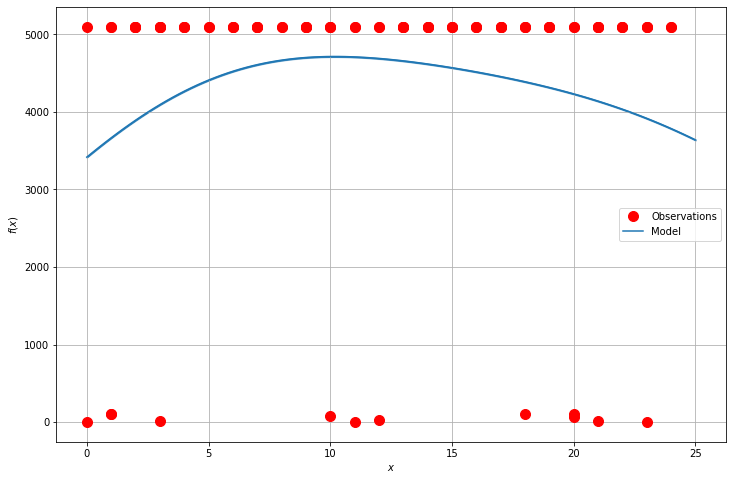

In [96]:
plot_gaussian_process(np.linspace(0,25,100),emukit_model)

## Perform Sensitivity Analysis

In [97]:
get_sobol_indices(emukit_model,parameter_space)

({'season_duration': array([1.00010097]),
  'gamma': array([0.01166655]),
  'mut_rate': array([0.01166655]),
  'T': array([0.01166655]),
  'target_area': array([0.01166655]),
  'gradnoise': array([0.01166655])},
 {'season_duration': array([0.98833345]),
  'gamma': array([-0.08512816]),
  'mut_rate': array([-0.08512816]),
  'T': array([-0.08512816]),
  'target_area': array([-0.08512816]),
  'gradnoise': array([-0.08512816])})